In [81]:
# HW2

# Took help from https://www.kaggle.com/dster/nyc-taxi-fare-starter-kernel-simple-linear-model/code for some 
# basic understanding

# all required imports
import numpy as np
import pandas as pd
#import geopy as gd
from geopy.distance import geodesic
import os
import math
import random
import datetime
import scipy as sp
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [82]:
# Q1. Data Cleaning

#feature_set = pd.read_csv("", converters= {}, low_memory=False, parse_dates=[2], infer_datetime_format=True, error_bad_lines=False, warn_bad_lines=True)

# For random sample: https://stackoverflow.com/questions/22258491/read-a-small-random-sample-from-a-big-csv-file-into-a-python-data-frame


#reading the training data
#train_data = pd.read_csv("./Data/train_small.csv", usecols=range(1,8), low_memory=False, error_bad_lines=False)
lines_percent = 0.00001
train_data = pd.read_csv("./Data/train.csv", usecols=range(1,8), low_memory=False, error_bad_lines=False, 
                        header=0, skiprows=lambda i: i>0 and random.random() > lines_percent)

#train_data = pd.read_csv("./Data/train.csv", nrows=2000, usecols=range(0,8), low_memory=False, error_bad_lines=False)

# removing invalid longitude rows
train_data = train_data[(train_data.pickup_latitude <= 90)]
train_data = train_data[(train_data.pickup_latitude >= -90)]
train_data = train_data[(train_data.dropoff_latitude <= 90)]
train_data = train_data[(train_data.dropoff_latitude >= -90)]

#function to add two new column containing the difference for lat, lon
def add_lat_lon_diff(td):
        td['abs_diff_longitude'] = (td.dropoff_longitude - td.pickup_longitude).abs()
        td['abs_diff_latitude'] = (td.dropoff_latitude - td.pickup_latitude).abs()

add_lat_lon_diff(train_data)
        
#setting invalid dates to NaN
train_data['pickup_datetime'] = train_data['pickup_datetime'].apply(pd.to_datetime, errors='coerce')

#setting invalid values to NaN
float_col = ['fare_amount', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count']
train_data[float_col] = train_data[float_col].apply(pd.to_numeric, errors='coerce')

#removing the rows containing NaN
train_data.dropna(how = 'any', axis = 'rows')

# removing outlier lat lon values
train_data = train_data[(train_data.abs_diff_longitude < 5.0) & (train_data.abs_diff_latitude < 5.0)]

# removing rows with value = 0 as it is not valid data
train_data = train_data[(train_data.pickup_longitude != 0) & (train_data.pickup_latitude != 0) & 
        (train_data.dropoff_longitude != 0) & (train_data.dropoff_latitude != 0) &
        (train_data.passenger_count > 0) & (train_data.fare_amount > 0) &
        (train_data.passenger_count <= 7)]

In [83]:
# adding new features

# function to add a new column containing distance between pickpup and dropoff
def euclid_distance(row_data):
    return (geodesic((row_data.pickup_latitude, row_data.pickup_longitude), (row_data.dropoff_latitude, row_data.dropoff_longitude)).miles)

def manhattan_distance(row_data):
    #return row_data.abs_diff_longitude + row_data.abs_diff_latitude
    hypotenuse = (geodesic((row_data.pickup_latitude, row_data.pickup_longitude), (row_data.dropoff_latitude, row_data.dropoff_longitude)).miles)
    sum_of_sides = 2 * math.sqrt((math.pow(hypotenuse, 2)/2))
    return sum_of_sides
    
#get hour:minute format
def hour_minute(row_data):
    return (row_data.pickup_datetime.hour) #* 100 + (row_data.pickup_datetime.minute)

#get day_of_week format
def day_of_week(row_data):
    return (row_data.pickup_datetime.weekday())

# adding new column for dates which were holidays in US
# Reference: https://www.kaggle.com/justjun0321/exploratory-geoclustering-to-modeling
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2009-01-01', end='2015-12-31').to_pydatetime()

def check_holiday(row_data):
    strip_date = datetime.datetime.strptime((str(row_data.pickup_datetime)[:10] ),'%Y-%m-%d')
    return 1 if strip_date in holidays else 0

def add_new_features(td):
    td['euclid_distance'] = td.apply(lambda row: euclid_distance(row), axis=1)
    td['distance_travelled'] = td.apply(lambda row: manhattan_distance(row), axis=1)
    td['time_of_day'] = td.apply(lambda row: hour_minute(row), axis=1)
    td['day_of_week'] = td.apply(lambda row: day_of_week(row), axis=1)
    td['holiday'] = td.apply(lambda row: check_holiday(row), axis=1)

add_new_features(train_data)

# removing rows with distance < 0.1 miles and more than 3000 miles
train_data = train_data[(train_data.distance_travelled > 0.1)]
train_data = train_data[(train_data.distance_travelled < 3000)]

# adding column for fare_per_km
train_data['fare_per_km'] = train_data.fare_amount/train_data.distance_travelled

# per km charges more than 50$/km seems wrong data
train_data = train_data[train_data.fare_per_km < 50]

In [84]:
# Q2.a) Pearson Correlation between Euclidean distance of the ride and the taxi fare

pearsonr(train_data.euclid_distance, train_data.fare_amount)

(0.8440490423808409, 6.750001461132754e-147)

In [85]:
# Q2.b) Pearson Correlation between Time of Day and distance
    
pearsonr(train_data.distance_travelled, train_data.time_of_day)

(-0.023064240687289895, 0.5938265173849161)

In [86]:
# Q2.c) Pearson Correlation between Time of Day and fare_amount

pearsonr(train_data.fare_amount, train_data.time_of_day)

(-0.03438976092118064, 0.42643836127323687)

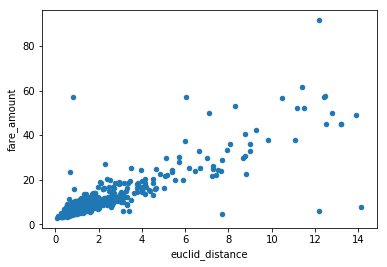

In [87]:
# Q3. a) Plot between Euclidean distance of the ride and the taxi fare

plot = train_data.plot.scatter('euclid_distance', 'fare_amount')

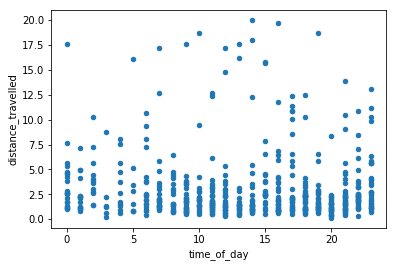

In [88]:
# Q3. b) Plot between Time of Day and distance_travelled

plot = train_data.plot.scatter('time_of_day', 'distance_travelled')

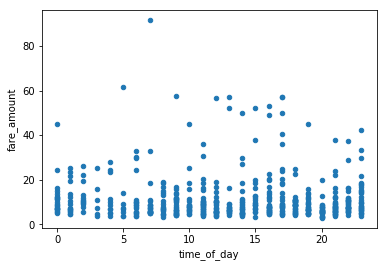

In [89]:
# Q3. c) Plot between Time of Day and fare_amount

plot = train_data.plot.scatter('time_of_day', 'fare_amount')

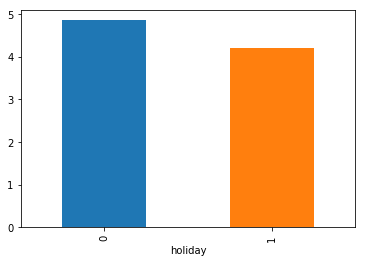

In [90]:
# Q4. Create an exciting plot of your own using the dataset that you think reveals something very interesting.
# Explain what it is, and anything else you learned.

# plot of data on weekdays
#train_data.groupby(train_data.time_of_day).mean()['fare_per_km'].plot('line')
#train_data["day_of_week"].plot.hist(bins=13)
#train_data.groupby(train_data.day_of_week).mean()['fare_per_km'].plot('bar')

train_data.groupby(train_data.holiday).mean()['fare_per_km'].plot('bar')
#train_data["holiday"].plot.hist(bins=2)

In [91]:
# reading test data and adding features which were added to training data


test_data = pd.read_csv("./Data/test.csv", usecols=range(0,7), low_memory=False, error_bad_lines=False)
test_data['pickup_datetime'] = test_data['pickup_datetime'].apply(pd.to_datetime, errors='coerce')

add_new_features(test_data)

In [92]:
# Q6.

#training the model

def get_basic_training_features(td):
    return np.column_stack((td.euclid_distance, np.ones(len(td))))

train_x = get_basic_training_features(train_data)
train_y = np.array(train_data['fare_amount'])

# Linear Regression model initialization
linear_regression_basic = LinearRegression()

# Training the Linear Regression Model
linear_regression_basic.fit(train_x, train_y)
print(linear_regression_basic.coef_)

# Predict fare_amount for training data to get calculate errors
pre_test_x = get_basic_training_features(train_data)
pre_test_y = linear_regression_basic.predict(pre_test_x)

# Mean squared error and variance
print("Mean squared error: %.5f" % mean_squared_error(train_data.fare_amount, pre_test_y))
print('Variance : %.5f' % r2_score(train_data.fare_amount, pre_test_y))

# Predict fare_amount for actual test data
test_x = get_basic_training_features(test_data)
test_y = linear_regression_basic.predict(test_x)

# write prediction to csv file
prediction_output = pd.DataFrame(
    {'key': test_data.key, 'fare_amount': test_y},
    columns = ['key', 'fare_amount'])
prediction_output.to_csv('prediction_with_basic_features.csv', index = False)


[3.5006331 0.       ]
Mean squared error: 29.44001
Variance : 0.71242


In [93]:
# Normalizing data
train_data['euclid_distance'] = train_data.euclid_distance / train_data.euclid_distance.max()
train_data['time_of_day'] = train_data.time_of_day / train_data.time_of_day.max()
train_data['day_of_week'] = train_data.day_of_week / train_data.day_of_week.max()
train_data['fare_amount'] = train_data.fare_amount / train_data.fare_amount.max()

In [94]:
# Q8.

# Training Linear regression with more features

def get_advanced_training_features(td):
    return np.column_stack((td.euclid_distance, td.time_of_day, td.day_of_week, np.ones(len(td))))

train_x = get_advanced_training_features(train_data)
train_y = np.array(train_data['fare_amount'])

# Linear Regression model initialization
linear_regression_adv = LinearRegression()

# Training the Linear Regression Model
linear_regression_adv.fit(train_x, train_y)
print(linear_regression_adv.coef_)

# Predict fare_amount for training data to get calculate errors
pre_test_x = get_advanced_training_features(train_data)
pre_test_y = linear_regression_adv.predict(pre_test_x)

# Mean squared error and variance
print("Mean squared error: %.5f" % mean_squared_error(train_data.fare_amount, pre_test_y))
print('Variance : %.5f' % r2_score(train_data.fare_amount, pre_test_y))

# Predict fare_amount
test_x = get_advanced_training_features(test_data)
test_y = linear_regression_adv.predict(test_x)

# write prediction to csv file
prediction_output = pd.DataFrame(
    {'key': test_data.key, 'fare_amount': test_y},
    columns = ['key', 'fare_amount'])
prediction_output.to_csv('prediction_with_advanced_features.csv', index = False)

[ 0.54026713 -0.00522488  0.00339721  0.        ]
Mean squared error: 0.00351
Variance : 0.71275


In [95]:
# Q8.

# Training KNN with more features

def get_advanced_training_features(td):
    return np.column_stack((td.euclid_distance, td.time_of_day, td.day_of_week, np.ones(len(td))))

train_x = get_advanced_training_features(train_data)
train_y = np.array(train_data['fare_amount'])

# KNN Regression model initialization
knn_regression_adv = KNeighborsRegressor(n_neighbors=200)

# Training the KNN Regression Model
knn_regression_adv.fit(train_x, train_y)

# Predict fare_amount for training data to get calculate errors
pre_test_x = get_advanced_training_features(train_data)
pre_test_y = knn_regression_adv.predict(pre_test_x)

# Mean squared error and variance
print("Mean squared error: %.5f" % mean_squared_error(train_data.fare_amount, pre_test_y))
print('Variance : %.5f' % r2_score(train_data.fare_amount, pre_test_y))

# Predict fare_amount
test_x = get_advanced_training_features(test_data)
test_y = knn_regression_adv.predict(test_x)

# write prediction to csv file
prediction_output = pd.DataFrame(
    {'key': test_data.key, 'fare_amount': test_y},
    columns = ['key', 'fare_amount'])
prediction_output.to_csv('prediction_with_knn.csv', index = False)

Mean squared error: 0.01000
Variance : 0.18196


In [96]:
# Q8.

# Training SVM with more features

def get_advanced_training_features(td):
    return np.column_stack((td.euclid_distance, td.time_of_day, td.day_of_week, np.ones(len(td))))

train_x = get_advanced_training_features(train_data)
train_y = np.array(train_data['fare_amount'])

# KNN Regression model initialization
svm = SVR(C=1.0, epsilon=0.05)

# Training the KNN Regression Model
svm.fit(train_x, train_y)

# Predict fare_amount for training data to get calculate errors
pre_test_x = get_advanced_training_features(train_data)
pre_test_y = svm.predict(pre_test_x)

# Mean squared error and variance
print("Mean squared error: %.5f" % mean_squared_error(train_data.fare_amount, pre_test_y))
print('Variance : %.5f' % r2_score(train_data.fare_amount, pre_test_y))

# Predict fare_amount
test_x = get_advanced_training_features(test_data)
test_y = svm.predict(test_x)

# write prediction to csv file
prediction_output = pd.DataFrame(
    {'key': test_data.key, 'fare_amount': test_y},
    columns = ['key', 'fare_amount'])
prediction_output.to_csv('prediction_with_svm.csv', index = False)

Mean squared error: 0.00368
Variance : 0.69943
